In [255]:
#standard packages
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from labellines import labelLine, labelLines

#administrative packages
import os
import datetime
mydate = datetime.datetime.now()
from datetime import date,timedelta
import time
start = time.time()

holidays = [
    '2017-01-02',
    '2017-01-16',
    '2017-02-20',
    '2017-05-29',
    '2017-07-04',
    '2017-09-04',
    '2017-11-10',
    '2017-11-23',
    '2017-11-24',
    '2017-12-22',
    '2017-12-25',
    '2017-12-26',
    '2017-12-27',
    '2017-12-28',
    '2017-12-29',
    '2018-01-01',
    '2018-01-15',
    '2018-02-19',
    '2018-04-28',
    '2018-07-04',
    '2018-09-03',
    '2018-11-12',
    '2018-11-22',
    '2018-11-23',
    '2018-12-24',
    '2018-12-25',
    '2018-12-26',
    '2018-12-27',
    '2018-12-28',
    '2018-12-31',
    '2019-01-01',
    '2019-01-21',
    '2019-02-18',
    '2019-05-27',
    '2019-07-04',
    '2019-09-02',
    '2019-11-11',
    '2019-11-28',
    '2019-11-29',
    '2019-12-24',
    '2019-12-25',
    '2019-12-26',
    '2019-12-27',
    '2019-12-30',
    '2019-12-31',
    '2020-01-01',
    '2020-01-20',
    '2020-02-17',
    '2020-05-25',
    '2020-07-03',
    '2020-09-07',
    '2020-11-11',
    '2020-11-26',
    '2020-11-27',
    '2020-12-24',
    '2020-12-25',
    '2020-12-28',
    '2020-12-29',
    '2020-12-30',
    '2020-12-31',
    '2020-12-01'
]
holidays = set([pd.Timestamp(h) for h in holidays])

In [256]:
local_folder = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting'
#local_folder = r'C:\Users\nelms\Dropbox\Python\WC'
os.chdir(local_folder)

In [257]:
file_name = r'BlueTest_Building_ResiAlt.csv'
tit = 'Residential Alteration'

BUILD = {
    'Application Submittal - Route':'Start',
    'Consolidated Comments - With Customer for Response':'Round_End',
    'Resubmittal or Revision - Route':'Round_Start',
    #'Building Review - Notes':'Pause',
    'Ready to Issue - Conditionally Approved':'End',
    'Ready to Issue - Issued':'End'
}

PLAN_30 = {
    'Intake Review - Application Accepted':'Start',
    'Consolidated Comments - Deemed Incomplete':'Round_End',
    'Resubmittal - Route for Review':'Round_Start',
    'Staff Analysis - Set for Hearing':'End',
    'Staff Analysis - Staff Level Decision':'End'
}

types = {
    'Commercial Alteration':(BUILD,(0,.5),'Spectral'),
    'Residential Alteration':(BUILD,(.5,1),'Spectral'),
    'Planning Project Design Review':(PLAN_30,(0,1),'RdYlGn')
}
for d in ['Building', 'Planning', 'Engineering']:
    if d in file_name:
        sub_folder = d
        break
os.chdir(os.path.join(os.getcwd(),d))
path = os.path.join(os.getcwd(), file_name)

In [258]:
Record_flows = pd.read_csv(path, skiprows=1)
if 'Record #' not in list(Record_flows):
    skip=1
    Record_flows = pd.read_csv(path, skiprows=skip)
else:
    skip=0
Record_cols = list(Record_flows)
#if 'Type of Work' in Record_cols:
#    dept, designation, permittype = pd.read_csv(path, skiprows=skip)[['Record Type', 'Type of Work', 'Subtype']].values[0]
#    tit= '{} {}'.format(designation, permittype)
#else:
#    dept, permittype = pd.read_csv(path, skiprows=skip)[['Record Type', 'Subtype']].values[0]
#    tit= '{} {}'.format(dept, permittype)

less, great = ('2017Q4', '2020Q1')
less, great = ((pd.to_datetime(less)).to_period('Q'), (pd.to_datetime(great)).to_period('Q'))



stat_d, cmapset, cmap = types[tit]

In [259]:
import logging
logger = logging.getLogger('ftpuploader')

def prepare_times(path):
    
    if 'Record #' not in list(pd.read_csv(path, skiprows=1)):
        skip=1
    else:
        skip=0
    temp = pd.read_csv(path, skiprows=skip)
    
    for t in [tt for tt in list(temp) if tt in ['Open Date', 'Status Date', 'DATE ASSIGNED', 'DATE STATUS', 'UPDATED DATE']]:
        temp[t] = pd.to_datetime(temp[t])
    
    temp['Task Status'] = temp['Task'] + ' - ' + temp['Status']

    temp_endfinder = temp[temp['Task Status'].isin(stat_d.keys())].copy()
    ends_after_Q = set(temp_endfinder.loc[(temp_endfinder['UPDATED DATE'].dt.to_period('Q')>less), 'Permit #'].values)
    temp = temp[temp['Permit #'].isin(ends_after_Q)]
    
    if 'DATE STATUS' not in list(temp):
        temp['DATE STATUS'] = temp['UPDATED DATE']
    temp = temp[['Permit #', 'Task Status', 'DATE ASSIGNED', 'DATE STATUS', 'UPDATED DATE']]
    temp = temp.rename(columns={'Permit #':'#'})
    temp = temp.set_index(['#', 'Task Status'])
    temp.sort_values(['#', 'UPDATED DATE'], inplace=True)
    
    IDs = {i:[] for i, ts in set(temp.index) if ts in ['Status - Assigned', 'Status - Received']}
    [IDs[i].append(ts) for i, ts in set(temp.index) if ts in ['Status - Assigned', 'Status - Received']]
    IDs = [k for k,v in IDs.items() if len(v) > 1]

    if 'Status - Received' in temp.index.get_level_values(1):
        for x in IDs:
            temp.loc[(x,'Status - Received'), 'DATE ASSIGNED'] = temp.loc[(x,'Status - Received'), 'DATE STATUS'].values[0]
            temp.loc[(x,'Status - Received'), 'DATE STATUS'] = temp.loc[(x,'Status - Assigned'), 'DATE STATUS'].values[0]
    
    return temp

def sum_days(strt, nd, busi=True):
    if busi == True:
        days = [d for d in pd.bdate_range(start=strt, end=nd).to_list() if d not in holidays]
    if busi == False:
        days = pd.date_range(start=strt, end=nd).to_list()
    return days

def check_days(srt, ned, a_list, t_list):
    s = [ss for ss in sum_days(srt, ned, busi=True) if ss not in t_list]
    t_list.update(s)
    a_list.append(len(s))
    return a_list, t_list

def get_rec_list(rec, parcs):
    temp = parcs.xs(rec).sort_values(['UPDATED DATE']).copy()
    temp.drop('UPDATED DATE', inplace=True, axis=1)
    temp.index = temp.index.map(stat_d)
    temp.reset_index(inplace=True)
    temp.reset_index(inplace=True)
    ts_df = temp[['Task Status', 'index', 'DATE ASSIGNED', 'DATE STATUS']].copy()
    ts = temp.loc[~temp['Task Status'].isna()][['Task Status', 'index', 'DATE ASSIGNED', 'DATE STATUS']].values
    if len(ts) == 0:
        ts = temp.loc[temp['index']==0][['Task Status', 'index', 'DATE ASSIGNED', 'DATE STATUS']].values     
    return ts_df, ts

def round_check(test_df, test):
    if len(np.where(test[:,0] == 'End')[0]) > 1:
        while len(np.where(test[:,0] == 'End')[0]) > 1:
            false_end = np.where(test[:,0] == 'End')[0][-1]
            test = np.delete(test, false_end, 0)
    elif len(np.where(test[:,0] == 'End')[0]) == 0:
        test[-1,0] = 'End'

    if (len(test) == 1) and (len(test) != len(test_df)): 
        if test[0,1] > 0:
            start_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE ASSIGNED'].values[0])
            route_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE STATUS'].values[0])
            test = np.vstack([np.array(['Start', 0, start_date, route_date]), test])
            n = True
    else:
        n = False
    round_check = {
        'Start':1,
        'Round_Start':1,
        'Round_End':0,
        'End':0
    }
    check = [round_check[l] for l in list(test[:,0])]

    f = 0
    for e,c in enumerate(check):
        if e == 0:
            if (c == 0)&(len(check)>1):
                test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                f += 1
            pass
        else:
            if c != cc:
                pass
            elif c == cc:
                if c == 0:
                    test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                    f += 1
                elif (c == 1)and(n==False):
                    #try:
                    index = test[e+f,1]
                    #except:
                    #    print(false_index)
                    if (index > 2)&(index-2 != test[e+f-1,1]): 
                        false_index = index-2
                    else:
                        false_index = index-1
                    try:
                        false_date = pd.to_datetime(test_df.loc[test_df['index'] == false_index, 'DATE STATUS'].values[0])
                    except:
                        print(index, test)
                        print(test_df.loc[test_df['index'] == index, 'DATE STATUS'])
                        break
                    test = np.insert(test, e + f, np.array(('temp_end', 
                                                                false_index, 
                                                                false_date, 
                                                                false_date)), 
                                         0)
                    #except Exception as exc:
                    #    print(false_index, index, e)
                    #    logger.error(str(exc))

                    f += 1
        ee = e
        cc = c
    if (ee > 0) & (cc == 1):
        print('yes')
        index = test[-1,1]
        false_index = index
        mx = test_df['index'].max()-1
        if mx == index:
            mx = test_df['index'].max()
        false_date = pd.to_datetime(test_df.loc[test_df['index'] == mx, 'DATE STATUS'].values[0])
        test = np.insert(test, len(test), np.array(('temp_end', 
                                                false_index, 
                                                false_date, 
                                                false_date)), 
                         0)  
    return test[:,2:]

def find_round_length(array, startindex):

    if len(array) > 1:
        endindex = startindex + 1
    else:
        endindex = startindex

    startdate = array[startindex]
    enddate = array[endindex]
    round_length = len(sum_days(startdate, enddate, busi=True))
    return round_length

def describe_rounds(rounds_arr):
    SUBMITTAL_DATE = rounds_arr[0][0]
    ROUTING_DATE = rounds_arr[0][1]

    DAYS_TILL_ROUTING = len(sum_days(SUBMITTAL_DATE, ROUTING_DATE, busi=True))-1

    END_DATE = rounds_arr[-1][1]

    TOTAL_DAYS = len(sum_days(SUBMITTAL_DATE, END_DATE, busi=False))

    updates = rounds_arr[:,1]

    if ((len(updates) % 2) != 0)and(len(updates)>1):
        print('not even', len(updates))
        
    DAYS_PER_ROUND = [find_round_length(updates, i) for i in range(0,len(updates), 2)]

    ROUNDS_COUNT = len(DAYS_PER_ROUND)

    PROCESSING_DAYS = sum(DAYS_PER_ROUND)
    
    return TOTAL_DAYS, PROCESSING_DAYS, ROUNDS_COUNT, DAYS_TILL_ROUTING, DAYS_PER_ROUND, SUBMITTAL_DATE, END_DATE

def get_counts(parcs):
    amts = set(parcs.index.get_level_values(0))
    
    temprecords = np.array(['Record #', 'Total Days', 'Working Days', 'Rounds', 'Days till Routing', 'Days per Round', 'Submittal Date', 'Complete Date']).reshape(1,8)
    for record_id in amts:
        #try:
        ts_df, ts = get_rec_list(record_id, parcs)
        temprounds = round_check(ts_df, ts)
        described_list = describe_rounds(temprounds)
        new_row = [record_id] + list(described_list)
        temprecords = np.vstack([temprecords, new_row])
        #except Exception as exc:
        #    print(record_id)
        #    logger.error(str(exc))
    
    records_df = pd.DataFrame(columns=temprecords[0,1:], data=temprecords[1:,1:], index=temprecords[1:,0])
    records_df.index.name = 'Record #'
    sum_columns = ['Total Days', 'Rounds', 'Working Days', 'Days till Routing']
    records_df[sum_columns] = records_df[sum_columns].astype(int)
    return records_df

def join_cates(old, new_path):
    temp = pd.read_csv(new_path, skiprows=1)[['Permit #',
                                             'Type of Work',
                                             #'Subtype',
                                             'CONST TYPE CODE',
                                             'Description']].rename(columns={'Permit #':'#', 'CONST TYPE CODE':'Con Code'})
    temp.drop_duplicates(inplace=True, keep='first')
    temp = temp.set_index(['#'])
    
    file_name = r'ConstCodes.csv'
    path = os.path.join(os.getcwd(), file_name)
    const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
    temp['Con Desc'] = temp['Con Code'].map(const_dict)
    return temp.join(old, how='outer', rsuffix='desc')

def get_reviews(path, let=False):
    let = let or False
    bb = prepare_times(path, prep=False)
    bbb = bb.loc[(bb['Task'].str.contains('Review'))&(bb['Status']=='Routed')].reset_index()[['#','Task Status', 'Task']].groupby(['#','Task Status']).count()
    bbbi = set(bbb.index.get_level_values(0))

    if let == True:
        bb_dict = {b:[''.join(sorted([b[0] for b in bbb.xs(b).index.values]))] for b in bbbi}
    else:
        bb_dict = {b:[len(bbb.xs(b))] for b in bbbi}

    tl = 1
    while len(bbb.loc[bbb['Task']>tl, 'Task']):
        if let == True:
            [bb_dict[b].append(''.join(sorted([b[0] for b in bbb.loc[bbb['Task']>tl].xs(b).index.values]))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        else:
            [bb_dict[b].append(len(bbb.loc[bbb['Task']>tl].xs(b))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        tl = tl + 1
    return bb_dict

Record_flows = prepare_times(path)

Records = get_counts(Record_flows)
#Record_flows = get_counts(Record_flows)

missing_end = 38
mising_end = 41
one = 98
test = 674

yes
yes
yes


### TEST

In [260]:
"""Record_flows = prepare_times(path)

def round_check(test_df, test):
    if len(np.where(test[:,0] == 'End')[0]) > 1:
        while len(np.where(test[:,0] == 'End')[0]) > 1:
            false_end = np.where(test[:,0] == 'End')[0][-1]
            test = np.delete(test, false_end, 0)
    elif len(np.where(test[:,0] == 'End')[0]) == 0:
        test[-1,0] = 'End'

    if (len(test) == 1) and (len(test) != len(test_df)): 
        if test[0,1] > 0:
            start_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE ASSIGNED'].values[0])
            route_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE STATUS'].values[0])
            test = np.vstack([np.array(['Start', 0, start_date, route_date]), test])
            n = True
    else:
        n = False
    round_check = {
        'Start':1,
        'Round_Start':1,
        'Round_End':0,
        'End':0
    }
    check = [round_check[l] for l in list(test[:,0])]

    f = 0
    for e,c in enumerate(check):
        if e == 0:
            if (c == 0)&(len(check)>1):
                test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                f += 1
            pass
        else:
            if c != cc:
                pass
            elif c == cc:
                if c == 0:
                    test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                    f += 1
                elif (c == 1)and(n==False):
                    #try:
                    index = test[e+f,1]
                    #except:
                    #    print(false_index)
                    if (index > 2)&(index-2 != test[e+f-1,1]): 
                        false_index = index-2
                    else:
                        false_index = index-1
                    try:
                        false_date = pd.to_datetime(test_df.loc[test_df['index'] == false_index, 'DATE STATUS'].values[0])
                    except:
                        print(index, test)
                        print(test_df.loc[test_df['index'] == index, 'DATE STATUS'])
                        break
                    test = np.insert(test, e + f, np.array(('temp_end', 
                                                                false_index, 
                                                                false_date, 
                                                                false_date)), 
                                         0)
                    #except Exception as exc:
                    #    print(false_index, index, e)
                    #    logger.error(str(exc))

                    f += 1
        ee = e
        cc = c
    if (ee > 0) & (cc == 1):
        print('yes')
        index = test[-1,1]
        false_index = index
        mx = test_df['index'].max()-1
        if mx == index:
            mx = test_df['index'].max()
        false_date = pd.to_datetime(test_df.loc[test_df['index'] == mx, 'DATE STATUS'].values[0])
        test = np.insert(test, len(test), np.array(('temp_end', 
                                                false_index, 
                                                false_date, 
                                                false_date)), 
                         0)  
    return test[:,2:]

temprecords = np.array(['Record #', 'Total Days', 'Working Days', 'Rounds', 'Days till Routing', 'Days per Round', 'Submittal Date', 'Complete Date']).reshape(1,8)

amts = list(Record_flows.index.get_level_values(0))
record_id = 'B171656' #amts[41]
parcs = Record_flows.copy()

ts_df, ts = get_rec_list(record_id, parcs)
temprounds = round_check(ts_df, ts)
described_list = describe_rounds(temprounds)
new_row = [record_id] + list(described_list)
temprecords = np.vstack([temprecords, new_row])"""

"Record_flows = prepare_times(path)\n\ndef round_check(test_df, test):\n    if len(np.where(test[:,0] == 'End')[0]) > 1:\n        while len(np.where(test[:,0] == 'End')[0]) > 1:\n            false_end = np.where(test[:,0] == 'End')[0][-1]\n            test = np.delete(test, false_end, 0)\n    elif len(np.where(test[:,0] == 'End')[0]) == 0:\n        test[-1,0] = 'End'\n\n    if (len(test) == 1) and (len(test) != len(test_df)): \n        if test[0,1] > 0:\n            start_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE ASSIGNED'].values[0])\n            route_date = pd.to_datetime(test_df.loc[test_df['index'] == 0, 'DATE STATUS'].values[0])\n            test = np.vstack([np.array(['Start', 0, start_date, route_date]), test])\n            n = True\n    else:\n        n = False\n    round_check = {\n        'Start':1,\n        'Round_Start':1,\n        'Round_End':0,\n        'End':0\n    }\n    check = [round_check[l] for l in list(test[:,0])]\n\n    f = 0\n    for e,c in

In [261]:
PLAN_30 = {
    'Intake Review - Application Accepted':'Start',
    'Status - Received':'Start',
    
    'Consolidated Comments - Deemed Incomplete':'Round_End',
    'Resubmittal - Route for Review':'Round_Start',
    
    'Staff Analysis - Set for Hearing':'End',
    'Staff Analysis - Staff Level Decision':'End'
}
#Recs = list(Record_flows.index.get_level_values(0).unique())
#Record_flows.xs(Recs[-3])

#Record_flows['Task'].unique()
#Record_flows.loc[Record_flows['Task']=='Staff Analysis', 'Status'].unique()
#DC = list(Record_flows.loc[(Record_flows['Task']=='Staff Analysis'), 'Permit #'].unique())

#IDs = {i:[] for i, ts in set(Record_flows.index) if ts in ['Status - Assigned', 'Status - Received']}
#[IDs[i].append(ts) for i, ts in set(Record_flows.index) if ts in ['Status - Assigned', 'Status - Received']]
#IDs = [k for k,v in IDs.items() if len(v) > 1]

#for x in IDs:
#    Record_flows.loc[(x,'Status - Received'), 'DATE ASSIGNED'] = Record_flows.loc[(x,'Status - Received'), 'DATE STATUS'].values[0]
#    Record_flows.loc[(x,'Status - Received'), 'DATE STATUS'] = Record_flows.loc[(x,'Status - Assigned'), 'DATE STATUS'].values[0]


#Record_flows.loc[(Record_flows.index.isin(IDs, level=0))&(Record_flows.index.isin(['Status - Received'], level=1)), 'DATE ASSIGNED'] = Record_flows.loc[(Record_flows.index.isin(IDs, level=0))&(Record_flows.index.isin(['Status - Received'], level=1)), 'DATE STATUS'].values[0]
#Record_flows.loc[(Record_flows.index.isin(IDs, level=0))&(Record_flows.index.isin(['Status - Received'], level=1)), 'DATE STATUS'] = Record_flows.loc[(Record_flows.index.isin(IDs, level=0))&(Record_flows.index.isin(['Status - Received'], level=1)), 'DATE STATUS'].values[0]

#.index.get_level_values(0)
                 #.isin(IDs)].select(lambda row: row[0] != '1995-96', axis=0)
"""temprecords = np.array(['Record #', 'Total Days', 'Working Days', 'Rounds', 'Days till Routing', 'Days per Round', 'Submittal Date', 'Complete Date']).reshape(1,8)
record_id = 'B190049'
parcs = BTI
ts_df, ts = get_rec_list(record_id, parcs)
temprounds = round_check(ts_df, ts)
described_list = describe_rounds(temprounds)
new_row = [record_id] + list(described_list)
temprecords = np.vstack([temprecords, new_row])

records_df = pd.DataFrame(columns=temprecords[0,1:], data=temprecords[1:,1:], index=temprecords[1:,0])
records_df.index.name = 'Record #'
sum_columns = ['Total Days', 'Rounds', 'Working Days', 'Days till Routing']
records_df[sum_columns] = records_df[sum_columns].astype(int)

list(range(0,len(updates), 2))"""

"temprecords = np.array(['Record #', 'Total Days', 'Working Days', 'Rounds', 'Days till Routing', 'Days per Round', 'Submittal Date', 'Complete Date']).reshape(1,8)\nrecord_id = 'B190049'\nparcs = BTI\nts_df, ts = get_rec_list(record_id, parcs)\ntemprounds = round_check(ts_df, ts)\ndescribed_list = describe_rounds(temprounds)\nnew_row = [record_id] + list(described_list)\ntemprecords = np.vstack([temprecords, new_row])\n\nrecords_df = pd.DataFrame(columns=temprecords[0,1:], data=temprecords[1:,1:], index=temprecords[1:,0])\nrecords_df.index.name = 'Record #'\nsum_columns = ['Total Days', 'Rounds', 'Working Days', 'Days till Routing']\nrecords_df[sum_columns] = records_df[sum_columns].astype(int)\n\nlist(range(0,len(updates), 2))"

# Analysis

### Grouping

In [262]:
def grping(layer, grp_fld, rn):
    agg_base = ['mean']
    layer['Permits'] = 1
    keep = ['Working Days', 'Days till Routing']
    rename_keep = {'Permits':'# of Permits', 'Working Days':'Avg # of Working Days', 'Rounds':'Avg # of Rounds', 'Days till Routing':'Avg # of Days till Routing'}
    
    aggs = {k:agg_base for k in keep}
    aggs['Permits'] = ['count']
    
    keep = ['Permits'] + keep
    
    b = layer.groupby(grp_fld).agg(aggs).astype(int)
    
    b.index = b.index.map(rn)
    b = b[keep].rename(columns=rename_keep, level=0)
    b.columns = b.columns.droplevel(level=1)
    
    layer.drop(columns='Permits', inplace=True)
        
    return b

def create_tempRecords(filtRecords):
    tempRecords = filtRecords.copy()
    r2l = [x for x in range(1,max(Records['Rounds'])) if x < 5]
    r2l[-1] = max(Records['Rounds'])
    r2d = {
                0 : "2 Rounds",
                1 : "3 Rounds",
                2 : "4 Rounds or More"
            }

    grp_by = [pd.cut(tempRecords['Rounds'], r2l, labels=False)]
    tempRecords_avg = grping(tempRecords, grp_by, r2d)

    
    if max(tempRecords.loc[tempRecords['Rounds']==1, 'Working Days']) == 1:
        r1l = [0,1]
    else:
        r1l = [0,1,max(tempRecords.loc[tempRecords['Rounds']==1, 'Working Days'])]
    grp_by = [pd.cut(tempRecords.loc[tempRecords['Rounds']==1, 'Working Days'], r1l, labels=False)]
    tempRecords_one_avg = grping(tempRecords.loc[tempRecords['Rounds']==1], grp_by, {
                0 : "Over-The-Counter",
                1 : "1 Round"
            })

    tempRecords_avg = tempRecords_one_avg.append(tempRecords_avg)
    
    tempRecords_avg.index.names = ['Rounds']
    
    keep = ['Working Days', 'Days till Routing']
    #All_Records = tempRecords[keep].groupby([True]*len(tempRecords)).agg(aggs).astype(int).rename({True:'All'}, axis=0)
    All_Records = grping(tempRecords, [True]*len(tempRecords), {
        np.isnan : 'All'
    })
    All_Records = All_Records.reset_index(drop=True).rename(index={0:'All'})
    tempRecords_avg = All_Records.append(tempRecords_avg)
    
    All_Records.index.name = 'Rounds'
    
    return tempRecords_avg

Records_avg = create_tempRecords(Records)

#file_name = r'ConstCodes.csv'
#path = os.path.join(os.getcwd(), file_name)
#const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
#BCo_avg = grping(BCo, 'Con Code', const_dict)

#Records.groupby('Rounds')[['Total Days', 'Rounds', 'Working Days', 'Days till Routing']].mean()

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [263]:
"""
def find_types(lyr, tlist=['datetime','period[Q-DEC]','O']):
    str_list = list(lyr.select_dtypes(include=tlist))
    no_str = [l for l in list(lyr) if l not in str_list]
    return no_str, str_list
    
def normalize_types(lyr):    
    lst, str_list = find_types(lyr, tlist=['datetime','period[Q-DEC]','O'])
    convert_dict = {s:str for s in str_list}
    no_dict = lyr[lst].dtypes.to_dict()
    convert_dict.update(no_dict)
    return lyr.astype(convert_dict)

def find_dupes(lyr):
    count = {}
    for i in list(lyr.index):
        if i not in count.keys():
            count[i] = 1
        elif i in count.keys():
            count[i] = count[i] + 1
    return set([k for k,v in count.items() if v > 1])

dupes = find_dupes(Records)
no_str, _ = find_types(Records)
Records[Records.index.isin(dupes)].drop_duplicates(subset=no_str, inplace=True)
"""

"\ndef find_types(lyr, tlist=['datetime','period[Q-DEC]','O']):\n    str_list = list(lyr.select_dtypes(include=tlist))\n    no_str = [l for l in list(lyr) if l not in str_list]\n    return no_str, str_list\n    \ndef normalize_types(lyr):    \n    lst, str_list = find_types(lyr, tlist=['datetime','period[Q-DEC]','O'])\n    convert_dict = {s:str for s in str_list}\n    no_dict = lyr[lst].dtypes.to_dict()\n    convert_dict.update(no_dict)\n    return lyr.astype(convert_dict)\n\ndef find_dupes(lyr):\n    count = {}\n    for i in list(lyr.index):\n        if i not in count.keys():\n            count[i] = 1\n        elif i in count.keys():\n            count[i] = count[i] + 1\n    return set([k for k,v in count.items() if v > 1])\n\ndupes = find_dupes(Records)\nno_str, _ = find_types(Records)\nRecords[Records.index.isin(dupes)].drop_duplicates(subset=no_str, inplace=True)\n"

In [264]:
def quarters(Ptype):
    if 'Quarter' not in list(Ptype):
        Ptype['Quarter'] = Ptype['Complete Date'].dt.to_period("Q")
    Ptype.sort_values('Quarter', inplace=True)
    Q = list(Ptype['Quarter'].unique())
    Q.sort()
    QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q)}
    return grping(Ptype, 'Quarter', QQ)
Records_Q = quarters(Records)

In [265]:
Q = list(Records['Quarter'].unique())
Q.sort()
QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q) if (q > less) and (q < great)}
#Recordsq_avg = grping(Records, 'Quarter', QQ)
#AI = list(Records_avg.index)*len(Q)
#QQQ = []
#[QQQ.extend([str(q)]*len(Records_avg.index)) for q in Q]
Records_Q = pd.DataFrame()
for qk,qv in QQ.items():
    try:
        temp = create_tempRecords(Records[Records['Quarter']==qk])
        temp['Quarter'] = qv
        temp.index.names = ['Rounds']
        temp.reset_index(inplace=True)
        temp.set_index(['Quarter', 'Rounds'], inplace=True)
        if len(Records_Q) == 0:
            Records_Q = temp
        else:
            Records_Q = pd.concat([Records_Q, temp])
    except:
        print(qk)

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Plotting

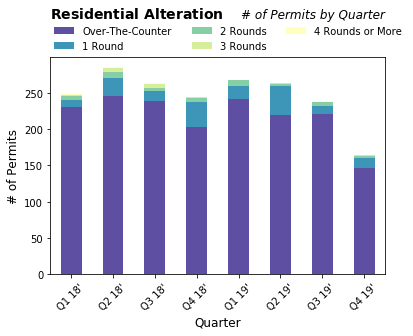

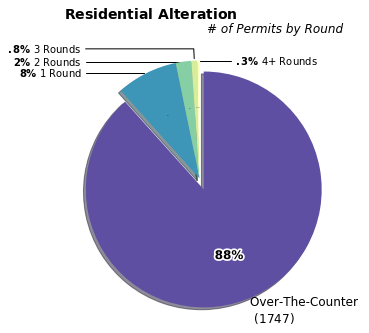

In [266]:
from matplotlib import cm
import matplotlib.pyplot as plt

def get_color(lst, scale = (0,1), type_cmap = 'Spectral'):
    a,b =  scale
    siz = len(list(lst))
    ar = np.linspace(a,b,siz)
    col = list(reversed(cm.get_cmap(type_cmap)(ar)))
    return col

def Qbar(temp, yy='# of Permits', title='Commercial Alteration'):
    yy = '# of Permits' or yy
    
    temp = temp.unstack(level=1)[yy].reindex(list(QQ.values()))
    temp = temp[[tl for tl in list(temp) if tl != 'All']].copy()
    if list(temp)[-1] == 'Over-The-Counter':
        new_order = ['Over-The-Counter'] + list(temp)[:-1]
        temp = temp[new_order]
    
    fig, ax = plt.subplots()
    
    color = get_color(temp, scale = cmapset, type_cmap = cmap)
    
    temp.plot(kind='bar', subplots=False, stacked = True, 
              color=color, ax=ax
                               )
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
            borderaxespad=0, frameon=False)
    ax.set_ylabel(yy, fontsize=12)
    ax.set_xlabel('Quarter', fontsize=12)
    legend_properties = {'weight':'bold'}
    
    ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.15, fontsize=14)
    ax.set_title('{} by Quarter'.format(yy), 
                 loc='right', y=1.15, style='italic')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    fig.savefig('{} - Permits by Quarter.png'.format(title), bbox_inches='tight') 

def Qpie(temp, yy='# of Permits', title='Commercial Alteration'):
    yy = '# of Permits' or yy
    
    temp = temp.loc[temp.index != 'All'].copy()
    
    sizes = [p/sum(temp[yy].to_list()) for p in temp[yy].to_list()]
    small_i = [e for e,s in enumerate(sizes) if s < .10]
    if len(small_i) < 2:
        small_i = []
    labels = temp.index.to_list()
    labels = [str(l) + ' \n $\mathit{ (' + str(a) + ') }$' for l,a in zip(labels, temp[yy].to_list())]
    small_i_labels = temp.index.to_list().copy()
    
    for e,l in enumerate(labels):
        if e in small_i:
            labels[e] = ''
            small_i_labels[e] = str(small_i_labels[e])
            if small_i_labels[e] == "4 Rounds or More":
                small_i_labels[e] = '4+ Rounds'
            siz = int(sizes[e]*100)
            if siz < 1:
                siz = str(round(sizes[e]*100,1)).replace('0','')
            small_i_labels[e] = '$\mathbf{ ' + str(siz) + '\% }$ ' + small_i_labels[e]
            
            
        elif e not in small_i:
            small_i_labels[e] = ''
    
    explode = [0] * len(labels)
    explode[0] = 0.1

    clr = get_color(labels, scale = cmapset, type_cmap = cmap)

    fig1, ax1 = plt.subplots(figsize=(5,5))
    patches, texts, autotexts = ax1.pie(sizes, explode=explode, 
                                        labels=labels, autopct='%1.f%%',
            shadow=True, counterclock=False, startangle=90, colors=clr)
    
    #centre_circle = plt.Circle((0,0),0.70,fc='white')
    #fig = plt.gcf()
    #fig.gca().add_artist(centre_circle)
    
    import matplotlib.patheffects as PathEffects
    
    for e,t in enumerate(texts):
        if e in small_i:
            sz = 10
        else:
            sz = 12
        t.set_fontsize(sz)
        
    for e,t in enumerate(autotexts):
        if e in small_i:
            sz = (0)
            t.set_fontsize(sz)
        else:
            sz, lw = (12,3.5)
            t.set_fontsize(sz)
            t.set_weight('bold')
            t.set_path_effects([PathEffects.withStroke(linewidth=lw, foreground='w')])
    
    #bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              #bbox=bbox_props, 
              zorder=0, va="center")
    prior_y = 0
    hori = 1
    side = 1
    for i, p in enumerate(patches):
        if small_i_labels[i] != '':
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))

            dif = abs(prior_y - y)
            #print(y, prior_y, dif)

            if dif < .02:
                hori = hori + .1
            if hori > 1.1:
                hori = 1
                side = -1

            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})


            ax1.annotate(small_i_labels[i], xy=(x, y), xytext=(side*1*np.sign(x), hori*y),
                        horizontalalignment=horizontalalignment, **kw)
            prior_y = y
        else:
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            prior_y = np.sin(np.deg2rad(ang))
        
        #print(x,y)
        
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    #fig1.suptitle('$\mathbf{' + title.replace(' ', ' \\ ') + '}$ by Rounds (#)')
    ax1.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.085, fontsize=14)
    ax1.set_title('{} by Round'.format(yy), 
                 loc='right', y=1.035, style='italic')
    fig1.savefig('{} - Permits by Round.png'.format(title), bbox_inches='tight') 

    plt.show()    
    
Qbar(Records_Q, title=tit)
Qpie(Records_avg, title=tit)

### To Excel

In [614]:
import datetime

def colnum_string(n):
    string = ""
    n = n + 1
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

def rng_create(A, one, B, two):
    return str(colnum_string(A)) + str(one) + ":" + str(colnum_string(B)) + str(two)

def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]

new_path = 'BlueTest_{}_{}.xlsx'.format(dept, tit.replace(' ',''))

import xlsxwriter as xlsx
wrkbk = xlsx.Workbook(new_path)
for OG, name in [(Records,tit), (Records_avg, 'Averages'), (Records_Q, 'Quarterly Averages')]:
    worksheet = wrkbk.add_worksheet(name)
    
    lyr = OG.copy()
    
    lyr = normalize_types(lyr)
    
    header = np.array([[lyr.index.name] + list(lyr)])
    data = lyr.reset_index().to_numpy()
    if data.shape[1] != header.shape[1]:        
        dif = data.shape[1] - header.shape[1]
        fix_head = [lyr.index.name] + list(lyr)
        for r in range(dif):
            fix_head = [' '] + fix_head
        header = np.array([fix_head])
    table = np.vstack((header,data))
    numRows,numColumns = table.shape
    
    idx = [0]
    if type(lyr.index) == pd.MultiIndex:
        idx.append(1)
        table[0,0:2] = list(lyr.index.names)
    else:
        table[0,0:1] = list(lyr.index.names)

    for c in range(numColumns):
        for r in range(numRows):
            format_dict = {'font_name':'Arial'}
            
            # TOP
            if (r == 0) & (c not in idx):
                format_dict['bottom'] = 2
                format_dict['bold'] = True
                format_dict['text_wrap'] = True
            # INDEX NAME
            if (r == 0) & (c in idx):
                format_dict['italic'] = True
            # RIGHT
            elif (r != 0) & (c == range(numColumns)[-1]):
                format_dict['right'] = 2
                if (r == range(numRows)[-1]):
                    format_dict['bottom'] = 2
            # LEFT
            elif (r != 0) & (c in idx):
                format_dict['bold'] = True
                if (1 not in idx)or(c == 1):
                    format_dict['right'] = 2
            # BOTTOM
            elif (r == range(numRows)[-1]) & (c not in idx):
                format_dict['bottom'] = 2
                if (c == range(numColumns)[-1]):
                    format_dict['right'] = 2
            item = table[r][c]
            
            cell_format = wrkbk.add_format(format_dict)
            worksheet.write(r, c, item, cell_format)
        if c not in idx:
            worksheet.set_column(c, c, 10)
        else:
            try:
                worksheet.set_column(c, c, len(max(table[:,c], key=len))+1)
            except:
                print(table[:,c])
            
wrkbk.close()


[None 'All' 'Over-The-Counter' '1 Round' '2 Rounds' '3 Rounds'
 '4 Rounds or More']


In [ ]:
#Records = get_counts(Record_flows)
#Record_flows = get_counts(Record_flows)
#Record_flows = Record_flows[(Record_flows['Complete Date'].dt.to_period('Q') > less)&(Record_flows['Complete Date'].dt.to_period('Q') < great)]
#Record_flows['Reviews'] = Record_flows.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_Const.csv'
#path = os.path.join(os.getcwd(), file_name)
#BCo = prepare_times(path, prep=True)
#BCo = get_counts(BCo)
#BCo = join_cates(BCo, path)
#BCo['Reviews'] = BCo.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_B_SDP.csv'
#path = os.path.join(os.getcwd(), file_name)
#SDP = prepare_times(path, prep=True, sdp=True)
#SDP = get_counts(SDP)

#SDP = join_cates(SDP, path)
#SDP['Reviews'] = SDP.index.map(get_reviews(path, let=True)).fillna(value=0)

#pd.DataFrame(ts)